In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import gc
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import model
import utils

class FL_AMC:

    def __init__(self, data_type):
        self.data_type = data_type  # "RML2016.10a" or "RML2016.10b"
        if data_type == 'RML2016.10a':
            self.file_path = f'D:/Research/Dataset_nocode/{self.data_type}/RML2016.10a_dict.pkl'
        elif data_type == 'RML2016.10b':
            self.file_path = f'D:/Research/Dataset_nocode/{self.data_type}/RML2016.10b.dat'

        self.global_comm_round = 20
        self.num_locals = 3


    def data_import(self):
        with open(self.file_path, 'rb') as file:
            pickle_data = pickle.load(file, encoding='latin1')

        data_item = list(pickle_data.items())
        data, SNR, label = [], [], []

        for i in range(len(data_item)):
            data.append(data_item[i][1])
            for j in range(len(data_item[i][1])):
                label.append(data_item[i][0][0])
                SNR.append(data_item[i][0][1])

        label_encoder = LabelEncoder()
        integer_labels = label_encoder.fit_transform(label)
        print(f"RML Dataset Length - 1st (data): {data[0].shape}, 2nd element(SNR): {len(SNR)}, 3rd element(label): {integer_labels}")

        label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Label Mapping:", label_mapping)

        return data, SNR, integer_labels


    def data_process(self, data, SNR, integer_labels, test_ratio=0.2):

        def one_hot_to_label(one_hot_encoded):
            lst = []
            for i in range(len(one_hot_encoded)):
                lst.append(np.argmax(one_hot_encoded[i]))

            return lst

        def one_hot_encode(labels):
            labels_reshaped = labels.reshape(-1, 1)
            encoder = OneHotEncoder(sparse_output=False)
            one_hot_encoded = encoder.fit_transform(labels_reshaped)

            return one_hot_encoded

        OH_label = one_hot_encode(integer_labels)

        if self.data_type == "RML2016.10a":
            X_data = np.array(data).reshape(1000*len(data), 2, 128, 1)
        elif self.data_type == "RML2016.10b":
            X_data = np.array(data).reshape(6000*len(data), 2, 128, 1)
        else:
            print("data_type either RML2016.10a or RML2016.10b")
            return None

        combined_data = list(zip(X_data, OH_label, SNR))
        random.shuffle(combined_data)
        shuffled_x_data, shuffled_y_label, shuffled_SNR = zip(*combined_data)
        x, y, z = np.array(shuffled_x_data), np.array(shuffled_y_label), np.array(shuffled_SNR)

        shuffled_indices = np.random.permutation(len(x))

        #test_ratio = 0.2  ##########  0.2 Test / 0.8 Train
        split_index = int(len(x) * (1 - test_ratio))

        x_train, x_test = x[shuffled_indices[:split_index]], x[shuffled_indices[split_index:]]
        y_train, y_test = y[shuffled_indices[:split_index]], y[shuffled_indices[split_index:]]
        z_train, z_test = z[shuffled_indices[:split_index]], z[shuffled_indices[split_index:]]

        print(f"x_train shape: {x_train.shape}, y_train: {y.shape}, x_test: {x_test.shape}, y_test: {y_test.shape}")

        return x, y, x_test, y_test

    # 이거 chatgpt 받은거

    def FedAvg(self, x, y, x_test, y_test):  #SNR_threshold, z => 추가 condition 넣을거면 넣기
        FedAvg_acc, FedAvg_loss = [], []
        global_model = model.build_model(y.shape[-1])

        for epoch in range(self.global_comm_round):
            accumulated_weights = [np.zeros_like(w) for w in global_model.get_weights()]

            for client in range(self.num_locals):
                gc.collect()
                random_indices = np.random.choice(len(x), size=1000, replace=False)
                x_tr, y_tr = x[random_indices], y[random_indices]

                ############################# Additional condition
                #x_tr, y_tr, z_tr = x[random_indices], y[random_indices], z[random_indices]
                #filtered = [(x, y) for x, y, z in zip(x_tr, y_tr, z_tr) if z > SNR_threshold]
                #if len(filtered) == 0:
                #    continue  # skip client with no valid data
                #X, Y = zip(*filtered)
                #############################

                local_model = model.build_model(y.shape[-1])
                local_model.set_weights(global_model.get_weights())
                local_model.fit(np.array(x_tr), np.array(y_tr), epochs=10, batch_size=128, verbose=0)
                #local_model.fit(np.array(X), np.array(Y), epochs=10, batch_size=128, verbose=0)

                accumulated_weights = [
                    acc + w for acc, w in zip(accumulated_weights, local_model.get_weights())
                ]

            average_weights = [w / self.num_locals for w in accumulated_weights]
            global_model.set_weights(average_weights)

            loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
            print(f'Global comm. round {epoch + 1} - Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
            FedAvg_loss.append(loss)
            FedAvg_acc.append(accuracy)

        return FedAvg_acc, FedAvg_loss

    def main(self):
        data, SNR, integer_labels = self.data_import()
        X_train, y_train, X_test, y_test = self.data_process(data, SNR, integer_labels, test_ratio=0.2)

        Acc, Loss = self.FedAvg(X_train, y_train, X_test, y_test)

        utils.FL_plot(Acc, Loss) #Visualize

        return Acc, Loss

In [2]:
acc, loss = FL_AMC("RML2016.10a").main()

RML Dataset Length - 1st (data): (1000, 2, 128), 2nd element(SNR): 220000, 3rd element(label): [9 9 9 ... 3 3 3]
Label Mapping: {np.str_('8PSK'): np.int64(0), np.str_('AM-DSB'): np.int64(1), np.str_('AM-SSB'): np.int64(2), np.str_('BPSK'): np.int64(3), np.str_('CPFSK'): np.int64(4), np.str_('GFSK'): np.int64(5), np.str_('PAM4'): np.int64(6), np.str_('QAM16'): np.int64(7), np.str_('QAM64'): np.int64(8), np.str_('QPSK'): np.int64(9), np.str_('WBFM'): np.int64(10)}
x_train shape: (176000, 2, 128, 1), y_train: (220000, 11), x_test: (44000, 2, 128, 1), y_test: (44000, 11)
Epoch 1 - Test Loss: 2.3123, Accuracy: 0.1476
Epoch 2 - Test Loss: 2.1537, Accuracy: 0.1842
Epoch 3 - Test Loss: 2.0229, Accuracy: 0.2658
Epoch 4 - Test Loss: 1.9407, Accuracy: 0.2881
Epoch 5 - Test Loss: 1.8732, Accuracy: 0.3105
Epoch 6 - Test Loss: 1.8236, Accuracy: 0.3147
Epoch 7 - Test Loss: 1.7862, Accuracy: 0.3312
Epoch 8 - Test Loss: 1.7438, Accuracy: 0.3383
Epoch 9 - Test Loss: 1.7200, Accuracy: 0.3457
Epoch 10 - T

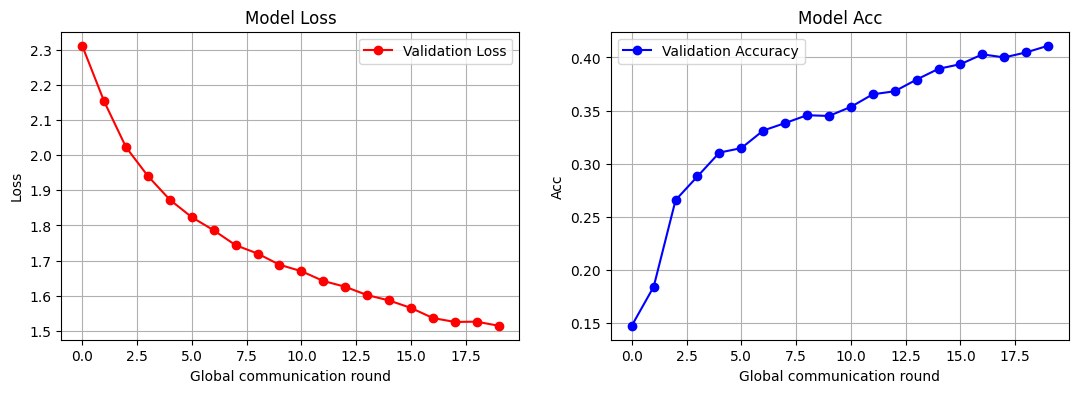

In [5]:
import importlib
importlib.reload(utils)

import utils
utils.FL_plot(acc,loss)